# 1. *installation*

In [ ]:
! pip install orjson
! pip install vaderSentiment

In [2]:
import json
import pandas as pd
import orjson
import heapq

import csv

# 2. *Filtering and Ranking Electronics Products (≤4⭐)*

In [3]:
file_path = r"D:\datathone_project\meta_Electronics.jsonl"

top_products = []

with open(file_path, 'rb') as f:
    for line in f:
        try:
            data = orjson.loads(line)
            
            asin = data.get("parent_asin")
            avg_rating = data.get("average_rating")
            num_ratings = data.get("rating_number")
            main_category=data.get("main_category")
            
            if main_category not in ["Amazon Devices", "All Electronics"]:
                continue  # Skip if not in allowed categories
            
            if asin and isinstance(avg_rating, (int, float)) and isinstance(num_ratings, int):
                if avg_rating <= 4:
                    heapq.heappush(top_products, (num_ratings, asin, avg_rating))
                    if len(top_products) > 35:
                        heapq.heappop(top_products)
        except orjson.JSONDecodeError:
            continue

top_products.sort(reverse=True)

top_asins = [asin for _, asin, _ in top_products]
print(top_asins)

['B07VTK654B', 'B07V2PS7M6', 'B078S34QZD', 'B01A11D2U2', 'B0BXLYHF9P', 'B07YYWM2LN', 'B09Y5D6NS5', 'B0BZ5C5QNB', 'B083Q433ZM', 'B081JCY2H4', 'B08CGQX4G9', 'B07TBRYDBV', 'B083BLRC9R', 'B08DLS9V5D', 'B07ZWJR9GD', 'B092JKFZPH', 'B0B5WDRB5K', 'B085DVTYHN', 'B0CG2L67DD', 'B084WT4WWK', 'B0C5MBN688', 'B0B1LSDYBM', 'B07L4BMD34', 'B09G2SWPKC', 'B088M68HFK', 'B0BKLDJXJ9', 'B07GTGHQHB', 'B0BPCF1D41', 'B07TCZBZ73', 'B0C1CST5HF', 'B07XCB3W6N', 'B07VNDRN5R', 'B07RQRX7RW', 'B0BL9BRHYR', 'B095X5ZW48']


In [ ]:


def find_parent_asins_from_jsonl(jsonl_file, partial_titles):
    parent_asins = {}

    with open(jsonl_file, 'r', encoding='utf-8') as file:
        for line in file:
            try:
                item = json.loads(line)
                item_title = item.get('title', '')
                
                for partial_title in partial_titles:
                    if item_title.startswith(partial_title):
                        parent_asins[partial_title] = item.get('parent_asin')
            except json.JSONDecodeError:
                continue  # Skip bad lines

    return [parent_asins.get(title) for title in partial_titles if title in parent_asins]

# Example usage
jsonl_file = r"D:\datathone_project\Electronics.jsonl"
titles_to_lookup = [
    "Jib True Wireless Earbud",
    "Skullcandy S2DUDZ023 Headphone",
    "Skullcandy Riff Wired On-Ear",
    "Skullcandy Crusher ANC Personalized"
]

parent_asin_list = find_parent_asins_from_jsonl(jsonl_file, titles_to_lookup)
print("Parent ASINs:", parent_asin_list)


Parent ASINs: []


# 3. *Filtering and Exporting Target ASIN Reviews to CSV*

In [5]:
target_asins = list(dict.fromkeys(top_asins + parent_asin_list))
# Using the metadata select the 15 parent asins with the most amount of reviews while the average rating stays below 3.7
target_asins = list(dict.fromkeys(
    target_asins + ['B0C5B8LFSM', 'B004Y9BG4C', 'B0BB5B1H73', 'B0C5BFJKJL']
))

input_file = r"D:\datathone_project\Electronics.jsonl"
output_file = "filtered_reviews.csv"

with open(output_file, mode="w", newline='', encoding="utf-8") as csvfile:
    writer = None

    with open(input_file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                record = orjson.loads(line)
                asin = record.get("parent_asin")

                if asin in target_asins:
                    if writer is None:
                        writer = csv.DictWriter(csvfile, fieldnames=record.keys())
                        writer.writeheader()

                    writer.writerow(record)

            except Exception as e:
                print("Skipping line due to error:", e)

In [6]:
input_file = r"D:\datathone_project\meta_Electronics.jsonl"
output_file = "filtered_meta.csv"

with open(output_file, mode="w", newline='', encoding="utf-8") as csvfile:
    writer = None

    with open(input_file, "r", encoding="utf-8") as f:
        for line in f:
            try:
                record = orjson.loads(line)
                asin = record.get("parent_asin")

                if asin in target_asins:
                    if writer is None:
                        writer = csv.DictWriter(csvfile, fieldnames=record.keys())
                        writer.writeheader()

                    writer.writerow(record)

            except Exception as e:
                print("Skipping line due to error:", e)

In [ ]:
filtered_meta_df = pd.read_csv("filtered_meta.csv")
filtered_meta_df

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
0,Home Audio & Theater,Skullcandy S2DUDZ023 Headphone Earbud.,4.1,381,"['Audio Headset Features: Lightweight, Enhance...",['Skullcandy Jib In-Ear Headphones 3.5mm Jack ...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '5.1 x 2.6 x 1.3 inches...,B004Y9BG4C,NaN
1,All Electronics,Skullcandy Riff Wired On-Ear Headphones - Whit...,4.2,3123,"['Refined acoustics', 'Collapsible, flat-foldi...","[""Lightweight, stylish headphones with a virtu...",24.95,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Skull candy use to be my favorite,...",Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '5.51 x 3.11 x 8.31 inc...,B0BB5B1H73,NaN
2,All Electronics,JBL Tune 225TWS True Wireless Earbud Headphone...,4.0,23293,['JBL PURE BASS SOUND: Powering festivals and ...,"[""JBL Tune 225TWS True Wireless Earbud Headpho...",79.95,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'I prefer a replacement. If the pro...,JBL,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '3.94 x 1.73 x 6.3 inch...,B08CGQX4G9,NaN
3,All Electronics,Skullcandy Riff Wired On-Ear Headphones - Black,4.4,14921,"['Refined acoustics', 'Collapsible, flat-foldi...",['Skullcandy Riff On-Ear Headphone - Black.'],16.49,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Review After 2 Years Of Use - Skul...,Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '8.46 x 5.59 x 3.15 inc...,B0C5BFJKJL,NaN
4,All Electronics,"KALINCO Smart Watch, Fitness Tracker with Hear...",4.0,20023,['All-day Activity Tracking: This smart watch ...,[],24.59,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Close Look at the Some of the feat...,KALINCO,"['Electronics', 'Wearable Technology', 'Smartw...","{'Item Weight': '3.84 ounces', 'Item model num...",B092JKFZPH,NaN
5,Amazon Devices,"Fire TV Recast, over-the-air DVR, 1 TB, 150 ho...",3.9,13772,['Fire TV Recast is a DVR that lets you watch ...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'First Impressions - This is GOOD b...,Amazon,[],{},B07GTGHQHB,NaN
6,All Electronics,Skullcandy Jib True Wireless Earbud with Micro...,4.3,16071,['Supreme Sound - Powered by 6mm drivers the J...,['Experience total freedom on a budget with Ji...,20.90,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Skullcandy Jib True Wireless', 'ur...",Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '7.8 x 5.28 x 1.69 inch...,B0C5B8LFSM,NaN
7,All Electronics,"elago Ear Hooks Designed for AirPods Pro 2, Ai...",3.9,20799,['Hook-shaped EarHooks are compatible with Air...,[],10.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'They keep my AirPods Pro from fall...,elago,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '1.38 x 0.35 x 2.36 inc...,B083BLRC9R,NaN
8,Amazon Devices,Echo Buds with Active Noise Cancellation (2021...,4.0,20763,['DYNAMIC AUDIO AND ACTIVE NOISE CANCELLATION ...,[],119.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Amazon Echo Buds 2nd Gen Unboxing ...,Amazon,[],{},B08DLS9V5D,NaN
9,All Electronics,"Popglory Smart Watch, Smartwatch with Blood Pr...",3.9,19862,['Guard your health all day: Using advanced se...,[],25.49,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'P22 Smartwatch - unpacking, settin...",Popglory,"['Electronics', 'Wearable Technology', 'Smartw...",{'Package Dimensions': '10.79 x 3.54 x 0.71 in...,B0B5WDRB5K,NaN


In [ ]:
filtered_meta_df1 = filtered_meta_df[filtered_meta_df['main_category'].isin(['All Electronics', 'Amazon Devices'])]

filtered_meta_df1

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
1,All Electronics,Skullcandy Riff Wired On-Ear Headphones - Whit...,4.2,3123,"['Refined acoustics', 'Collapsible, flat-foldi...","[""Lightweight, stylish headphones with a virtu...",24.95,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Skull candy use to be my favorite,...",Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '5.51 x 3.11 x 8.31 inc...,B0BB5B1H73,NaN
2,All Electronics,JBL Tune 225TWS True Wireless Earbud Headphone...,4.0,23293,['JBL PURE BASS SOUND: Powering festivals and ...,"[""JBL Tune 225TWS True Wireless Earbud Headpho...",79.95,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'I prefer a replacement. If the pro...,JBL,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '3.94 x 1.73 x 6.3 inch...,B08CGQX4G9,NaN
3,All Electronics,Skullcandy Riff Wired On-Ear Headphones - Black,4.4,14921,"['Refined acoustics', 'Collapsible, flat-foldi...",['Skullcandy Riff On-Ear Headphone - Black.'],16.49,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Review After 2 Years Of Use - Skul...,Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '8.46 x 5.59 x 3.15 inc...,B0C5BFJKJL,NaN
4,All Electronics,"KALINCO Smart Watch, Fitness Tracker with Hear...",4.0,20023,['All-day Activity Tracking: This smart watch ...,[],24.59,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Close Look at the Some of the feat...,KALINCO,"['Electronics', 'Wearable Technology', 'Smartw...","{'Item Weight': '3.84 ounces', 'Item model num...",B092JKFZPH,NaN
5,Amazon Devices,"Fire TV Recast, over-the-air DVR, 1 TB, 150 ho...",3.9,13772,['Fire TV Recast is a DVR that lets you watch ...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'First Impressions - This is GOOD b...,Amazon,[],{},B07GTGHQHB,NaN
6,All Electronics,Skullcandy Jib True Wireless Earbud with Micro...,4.3,16071,['Supreme Sound - Powered by 6mm drivers the J...,['Experience total freedom on a budget with Ji...,20.90,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Skullcandy Jib True Wireless', 'ur...",Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '7.8 x 5.28 x 1.69 inch...,B0C5B8LFSM,NaN
7,All Electronics,"elago Ear Hooks Designed for AirPods Pro 2, Ai...",3.9,20799,['Hook-shaped EarHooks are compatible with Air...,[],10.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'They keep my AirPods Pro from fall...,elago,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '1.38 x 0.35 x 2.36 inc...,B083BLRC9R,NaN
8,Amazon Devices,Echo Buds with Active Noise Cancellation (2021...,4.0,20763,['DYNAMIC AUDIO AND ACTIVE NOISE CANCELLATION ...,[],119.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Amazon Echo Buds 2nd Gen Unboxing ...,Amazon,[],{},B08DLS9V5D,NaN
9,All Electronics,"Popglory Smart Watch, Smartwatch with Blood Pr...",3.9,19862,['Guard your health all day: Using advanced se...,[],25.49,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'P22 Smartwatch - unpacking, settin...",Popglory,"['Electronics', 'Wearable Technology', 'Smartw...",{'Package Dimensions': '10.79 x 3.54 x 0.71 in...,B0B5WDRB5K,NaN
10,All Electronics,"Donerton Smart Watch, Fitness Tracker for Andr...",3.9,12186,['heart rate monitor and pedometer: fitness tr...,[],29.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Review Donerton Smart Watch. How ...,Donerton,"['Electronics', 'Wearable Technology', 'Smartw...",{'Package Dimensions': '6.34 x 3.74 x 1.06 inc...,B0BL9BRHYR,NaN


In [ ]:
rows_to_drop = [1,2,3,5,6,11,13,14,15,18,22,24,25,26,28,29,31,32,33] # manually curated

# Drop those rows
filtered_meta_df11 = filtered_meta_df1.drop(index=rows_to_drop)
filtered_meta_df11

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together
4,All Electronics,"KALINCO Smart Watch, Fitness Tracker with Hear...",4.0,20023,['All-day Activity Tracking: This smart watch ...,[],24.59,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Close Look at the Some of the feat...,KALINCO,"['Electronics', 'Wearable Technology', 'Smartw...","{'Item Weight': '3.84 ounces', 'Item model num...",B092JKFZPH,NaN
7,All Electronics,"elago Ear Hooks Designed for AirPods Pro 2, Ai...",3.9,20799,['Hook-shaped EarHooks are compatible with Air...,[],10.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'They keep my AirPods Pro from fall...,elago,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '1.38 x 0.35 x 2.36 inc...,B083BLRC9R,NaN
8,Amazon Devices,Echo Buds with Active Noise Cancellation (2021...,4.0,20763,['DYNAMIC AUDIO AND ACTIVE NOISE CANCELLATION ...,[],119.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Amazon Echo Buds 2nd Gen Unboxing ...,Amazon,[],{},B08DLS9V5D,NaN
9,All Electronics,"Popglory Smart Watch, Smartwatch with Blood Pr...",3.9,19862,['Guard your health all day: Using advanced se...,[],25.49,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'P22 Smartwatch - unpacking, settin...",Popglory,"['Electronics', 'Wearable Technology', 'Smartw...",{'Package Dimensions': '10.79 x 3.54 x 0.71 in...,B0B5WDRB5K,NaN
10,All Electronics,"Donerton Smart Watch, Fitness Tracker for Andr...",3.9,12186,['heart rate monitor and pedometer: fitness tr...,[],29.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Review Donerton Smart Watch. How ...,Donerton,"['Electronics', 'Wearable Technology', 'Smartw...",{'Package Dimensions': '6.34 x 3.74 x 1.06 inc...,B0BL9BRHYR,NaN
12,All Electronics,"Bluetooth 5.0 Wireless Earbuds, Bluedio Hi(Hur...",3.7,22167,['♪【Bluetooth 5. 0 & Superior Sound Quality】- ...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Hi Operation Tips', 'url': 'https:...",Bluedio,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '2.36 x 1.46 x 2.66 inc...,B07TBRYDBV,NaN
16,All Electronics,Skullcandy Indy Evo True Wireless In-Ear Bluet...,4.0,31354,['Note : If the size of the earbud tips does n...,"['""Wires out, colors in, Indy Evo is the true ...",30.64,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Watch Before You Buy - Skullcandy ...,Skullcandy,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '7.28 x 4.61 x 1.38 inc...,B0BXLYHF9P,NaN
17,All Electronics,ICARERSPACE Ear Hooks Compatible with Apple Ai...,3.8,15807,['KEEP AIRPODS STAY IN YOUR EARS: C shap earho...,[],12.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Ear Hooks Apple Airpods: PROS & CO...,ICARERSPACE,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Package Dimensions': '6.85 x 3.39 x 0.39 inc...,B0B1LSDYBM,NaN
19,Amazon Devices,Echo Auto (1st gen) - Hands-free Alexa in your...,4.0,136938,['Add Alexa to your car - Connects to the Alex...,[],49.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Alexa on the Go!', 'url': 'https:/...",Amazon,[],{},B07VTK654B,NaN
20,All Electronics,"HAYLOU True Wireless Earbuds, GT1 Bluetooth 5....",4.0,12255,"['9 New Updates: Bluetooth 5. 0, superior soun...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Unboxing haylou earbuds', 'url': '...",HAYLOU,"['Electronics', 'Headphones, Earbuds & Accesso...",{'Product Dimensions': '1.97 x 1.18 x 1.18 inc...,B07VNDRN5R,NaN


In [ ]:
# Save DataFrame to CSV
filtered_meta_df11.to_csv("filtered_meta_df1.csv", index=False)


In [ ]:
import pandas as pd
#'B0C5B8LFSM'+'B004Y9BG4C'+'B0BB5B1H73'+'B0C5BFJKJL'
#  Set the target parent_asin
target_parent_asin = "B0BXLYHF9P"
# target_parent_asin = 'B0C5BFJKJL' 




# Load your review CSV file
input_file = r"D:\datathone_project\filtered_reviews.csv"  
df = pd.read_csv(input_file)

#  Filter rows where parent_asin matches
filtered_df = df[df['parent_asin'] == target_parent_asin]

#  Save the filtered data to a new CSV
output_file = f"filtered_reviews_final.csv"
filtered_df.to_csv(output_file, index=False)

print(f"Filtered reviews saved to: {output_file}")


Filtered reviews saved to: filtered_reviews_final.csv


In [ ]:
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#  Load the CSV
file_path = r'D:\datathone_project\filtered_reviews_final.csv'
df = pd.read_csv(file_path)

# Text preprocessing function
import re
import string
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'(#[A-Za-z0-9_]+)|(@[A-Za-z0-9_]+)|(http\S+)', '', text)
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'\[.*?\]', '', text)  # remove [junk]
    text = re.sub(r'\bB0[A-Z0-9]{8}\b', '', text)  # remove ASINs
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


# Apply preprocessing to the text column
df['text'] = df['text'].fillna('')
df['cleaned_text'] = df['text'].apply(preprocess_text)

# VADER Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
df['vader_sentiment'] = df['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_label'] = df['vader_sentiment'].apply(get_sentiment_label)

# Step 5: Convert VADER score to Amazon-style star rating
def vader_to_star(score):
    if score >= 0.75:
        return 5
    elif score >= 0.5:
        return 4
    elif score >= 0.05:
        return 3
    elif score >= -0.05:
        return 2
    elif score >= -0.5:
        return 1


df['vader_star_rating'] = df['vader_sentiment'].apply(vader_to_star)

columns = ['vader_star_rating'] + [col for col in df.columns if col != 'vader_star_rating']
df = df[columns]
# Step 6: Save to CSV
output_path = r'vader_cleaned_with_stars.csv'
df.to_csv(output_path, index=False)
print(f"\n✅ Cleaned, analyzed, and saved to: {output_path}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Divy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



✅ Cleaned, analyzed, and saved to: vader_cleaned_with_stars.csv


In [ ]:
# Display a comparison between actual rating and VADER-predicted star rating
comparison_table = df[['rating', 'vader_star_rating', 'vader_label', 'text']].head(60)  # show first 20 rows for demo
print(comparison_table.to_string(index=False))


 rating  vader_star_rating vader_label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# 4. *📊 Comparing Real Star Ratings vs. VADER Predicted Star Ratings*

<Figure size 1400x800 with 0 Axes>

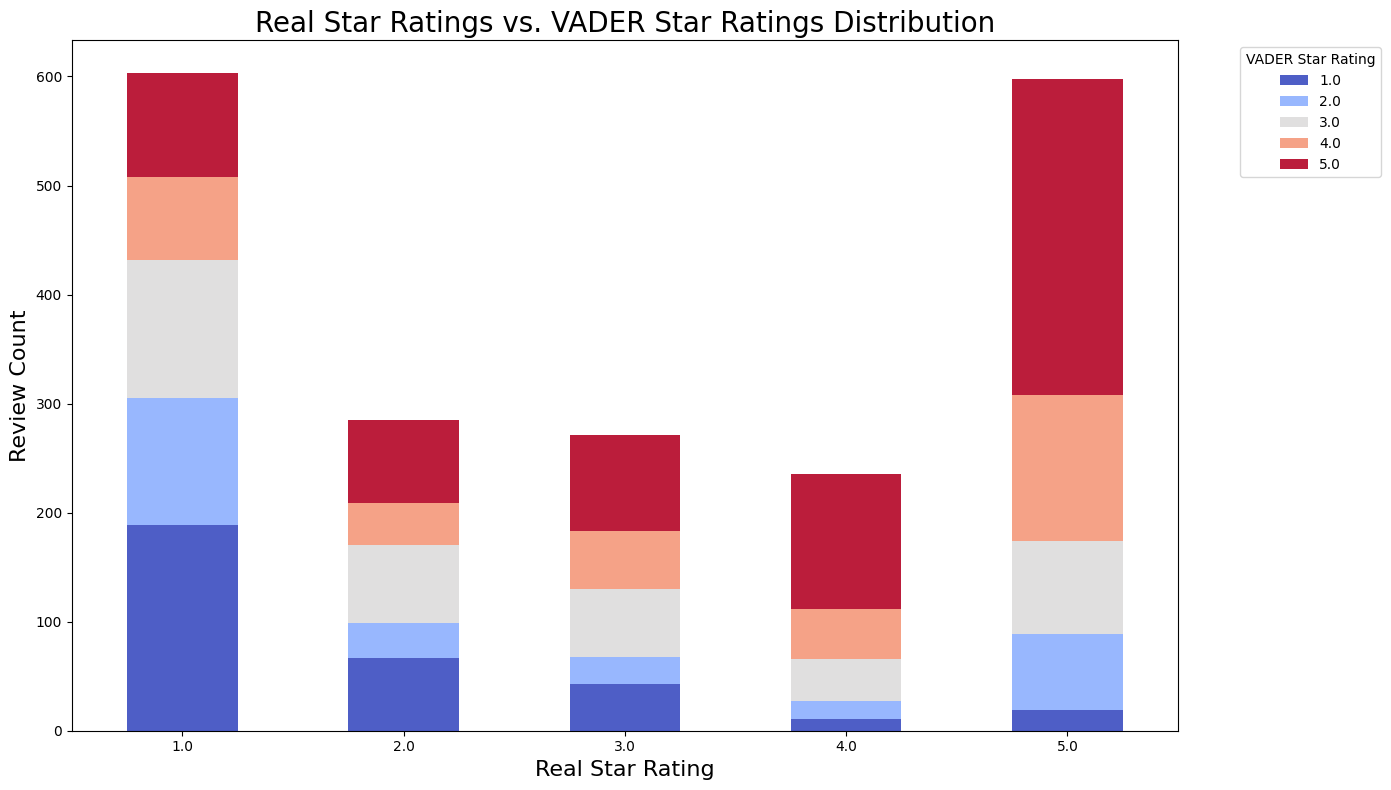

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV with the added VADER star ratings
file_path = r'D:\datathone_project\vader_cleaned_with_stars.csv'
df = pd.read_csv(file_path)

# Create a cross-tab to count the mismatches
mismatch_df = pd.crosstab(df['rating'], df['vader_star_rating'])

# Plot the grouped bar chart
plt.figure(figsize=(14, 8))
mismatch_df.plot(kind='bar', stacked=True, colormap='coolwarm', alpha=0.9, figsize=(14, 8))

# Adding titles and labels
plt.title('Real Star Ratings vs. VADER Star Ratings Distribution', fontsize=20)
plt.xlabel('Real Star Rating', fontsize=16)
plt.ylabel('Review Count', fontsize=16)
plt.xticks(rotation=0)
plt.legend(title='VADER Star Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


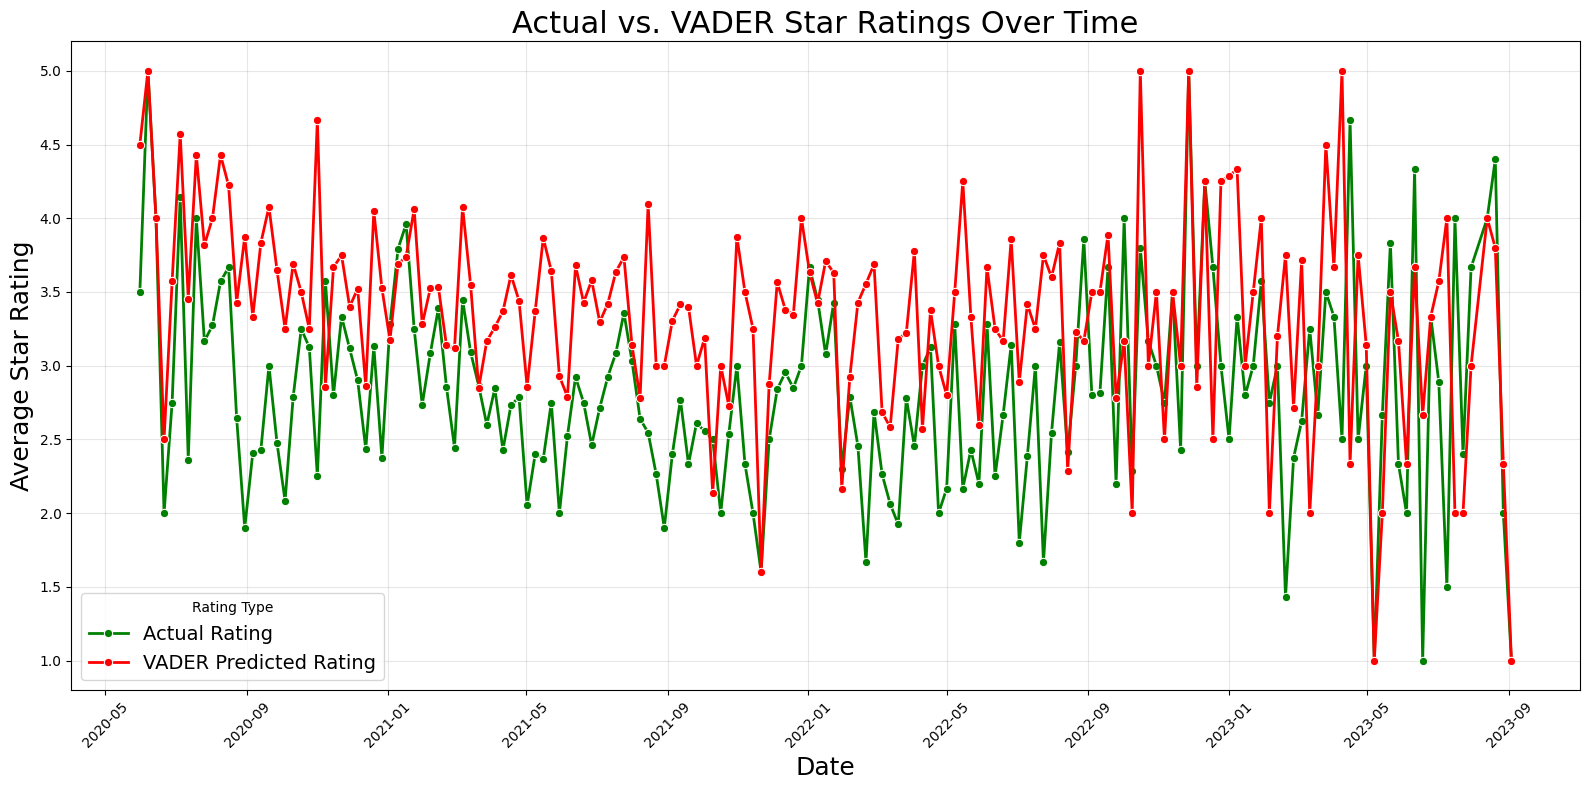

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = r'D:\datathone_project\vader_cleaned_with_stars.csv'
df = pd.read_csv(file_path)

# **Convert timestamp from Unix milliseconds to datetime**
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# **Group data by week to smooth the trend lines**
time_df = df.resample('W', on='timestamp').agg({
    'rating': 'mean',
    'vader_star_rating': 'mean'
}).reset_index()

# **Plot the line graph**
plt.figure(figsize=(16, 8))
sns.lineplot(x='timestamp', y='rating', data=time_df, marker='o', label='Actual Rating', color='green', linewidth=2)
sns.lineplot(x='timestamp', y='vader_star_rating', data=time_df, marker='o', label='VADER Predicted Rating', color='red', linewidth=2)

# **Add titles and labels**
plt.title('Actual vs. VADER Star Ratings Over Time', fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Average Star Rating', fontsize=18)
plt.xticks(rotation=45)
plt.legend(title='Rating Type', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()

# **Show the plot**
plt.show()


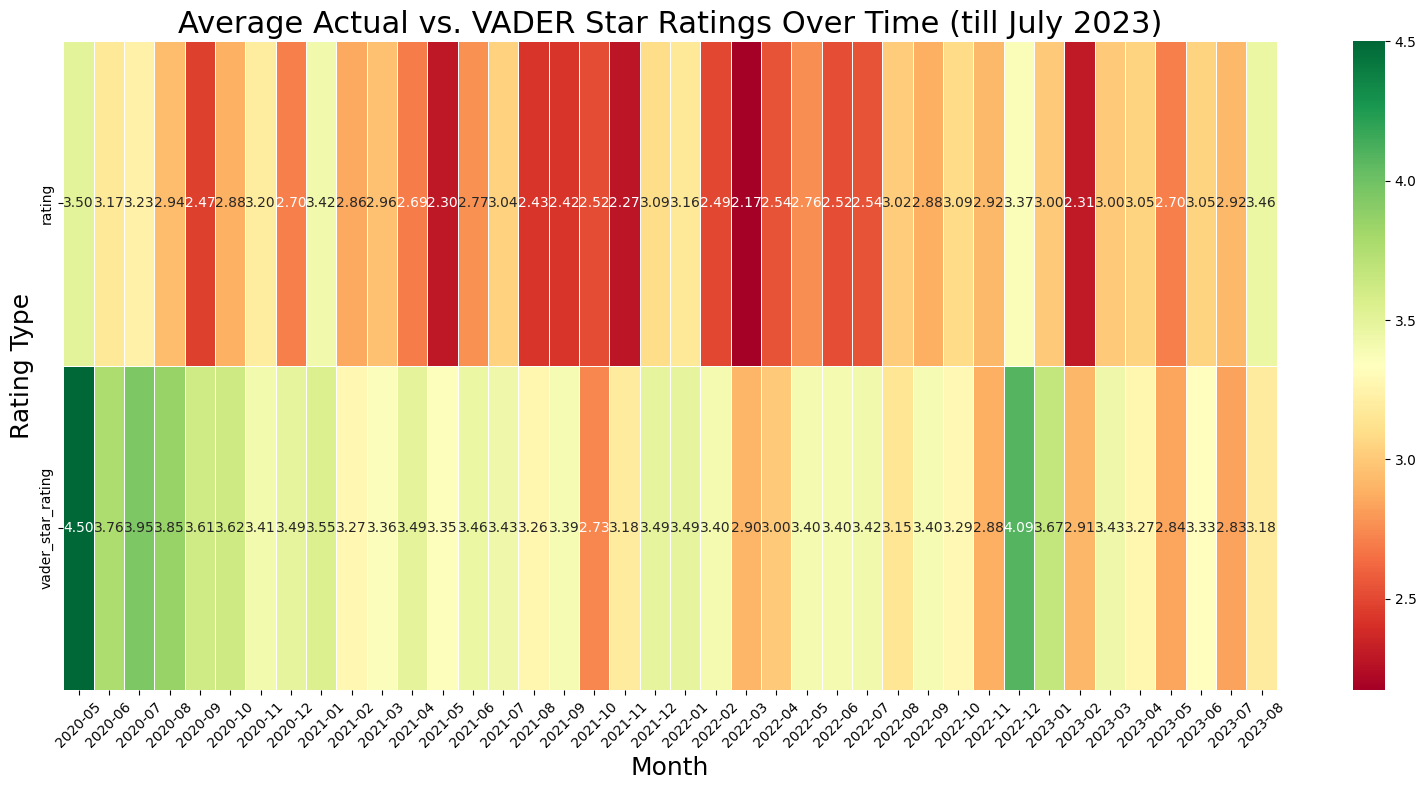

In [ ]:
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path = r'D:\datathone_project\vader_cleaned_with_stars.csv'
df = pd.read_csv(file_path)

# Convert Unix timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Extract month and year for grouping
df['year_month'] = df['timestamp'].dt.to_period('M')

# ✅ Filter only up to July 2023


# Create a pivot table for the heatmap
pivot_table = df.groupby(['year_month'])[['rating', 'vader_star_rating']].mean().reset_index()

# Plot the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_table.set_index('year_month').T, cmap='RdYlGn', annot=True, fmt=".2f", linewidths=0.5)

# Add titles and labels
plt.title('Average Actual vs. VADER Star Ratings Over Time (till July 2023)', fontsize=22)
plt.xlabel('Month', fontsize=18)
plt.ylabel('Rating Type', fontsize=18)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 5. *VADER Sentiment Distribution*

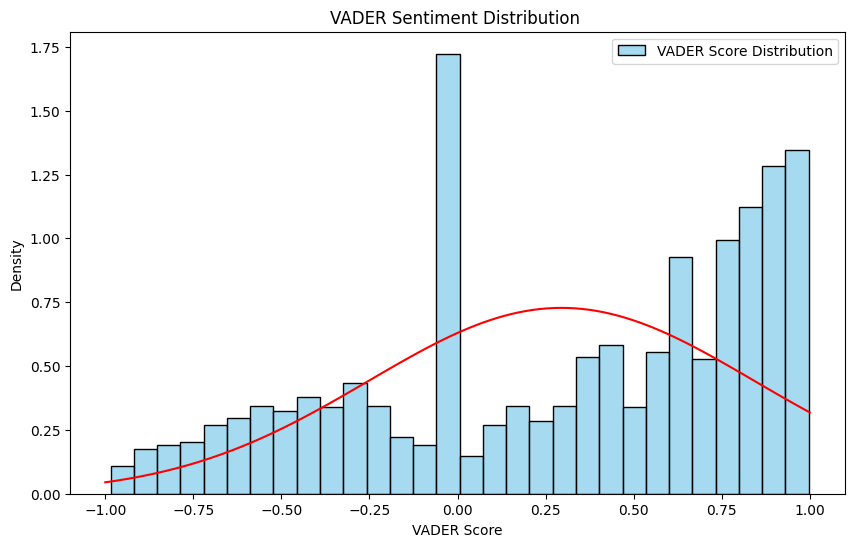

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

file_path = r'D:\datathone_project\vader_cleaned_with_stars.csv'
df = pd.read_csv(file_path)
# Compute mean and std
mean = df['vader_sentiment'].mean()
std = df['vader_sentiment'].std()

# Plot histogram with Gaussian fit
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_sentiment'], kde=False, stat='density', bins=30, color='skyblue', label='VADER Score Distribution')

# Plot normal distribution curve
x = np.linspace(-1, 1, 100)
plt.plot(x, norm.pdf(x, mean, std), color='red')
plt.title('VADER Sentiment Distribution ')
plt.xlabel('VADER Score')
plt.ylabel('Density')
plt.legend()
plt.show()
